# StackOverflow Data 2022: From Raw Survey to Usable Insights

This project involves cleaning and normalizing data from the StackOverflow Developer Survey to analyze current tech skills and forecast future trends. The code documented here transforms raw, unprocessed responses into a refined dataset, ready for insight extraction.

source from "https://stackoverflow.com/"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Stack Overflow survey results into a DataFrame "df"
csv_file = "survey_results_public.csv"

try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Error: File '{csv_file}' not found.")
except pd.errors.EmptyDataError:
    print(f"Error: File '{csv_file}' is empty or contains no data.")
except pd.errors.ParserError:
    print(f"Error: Failed to parse the CSV file '{csv_file}'.")

# Display rows of the dataframe
df.shape[0]

73268

In [3]:
# Check for duplicated responses in the survey data
df.duplicated().sum()

0

In [4]:
# # Display the column names in the dataframe
df.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'RemoteWork',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline',
       'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'BuyNewTool', 'Country', 'Currency',
       'CompTotal', 'CompFreq', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysProfessional use',
       'OpSysPersonal use', 'VersionControlSystem', 'VCInteraction',
       'VCHostingPersonal use', 'VCHostingProfessional use',
       'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith',
       'OfficeStackSyncHaveWork

In [5]:
# Examing respondent types
df["MainBranch"].value_counts()

I am a developer by profession                                                   53507
I am learning to code                                                             6309
I am not primarily a developer, but I write code sometimes as part of my work     5794
I code primarily as a hobby                                                       4865
None of these                                                                     1497
I used to be a developer by profession, but no longer am                          1296
Name: MainBranch, dtype: int64

In [6]:
# For the purpose of this analysis, we only want to include people who code for their work
df = df[(df["MainBranch"] == "I am a developer by profession") | 
   (df["MainBranch"] == "I am not primarily a developer, but I write code sometimes as part of my work") ]

# Display rows of the dataframe
df.shape[0]

59301

In [7]:
# Checking if the survey containing information on BI tools.
# Check if "tableau" exists in any column of the dataframe
is_tableau_present = df.astype(str).apply(lambda x: x.str.contains("tableau", case=False)).any().any()

# Print the result
print(is_tableau_present)

False


In [8]:
# Confirm if null values exist in the columns to be used for analysis
df['LanguageHaveWorkedWith'].isna().sum()

301

In [9]:
# It appears that the data was collected without filtering out 'null' values.
# List of columns that we are intrested to analyze
columns_intrested = ["LanguageHaveWorkedWith", "LanguageWantToWorkWith",
                     "DatabaseHaveWorkedWith", "DatabaseWantToWorkWith", 
                     "PlatformHaveWorkedWith", "PlatformWantToWorkWith", 
                     "WebframeHaveWorkedWith", "WebframeWantToWorkWith"]

# Dropping 'nulls' from the columns intended for analysis.
df_new = df.dropna(subset=columns_intrested)

# Print the number of rows and columns in the new DataFrame after dropping 'nulls'.
df_new.shape

(25650, 79)

In [10]:
# Preview the structure and format of the selected columns in our data
df_new[columns_intrested].head(5)

,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith
4,C#;HTML/CSS;JavaScript;SQL;Swift;TypeScript,C#;Elixir;F#;Go;JavaScript;Rust;TypeScript,Cloud Firestore;Elasticsearch;Microsoft SQL Se...,Cloud Firestore;Elasticsearch;Firebase Realtim...,Firebase;Microsoft Azure,Firebase;Microsoft Azure,Angular;ASP.NET;ASP.NET Core ;jQuery;Node.js,Angular;ASP.NET Core ;Blazor;Node.js
7,C;C++;HTML/CSS;Java;JavaScript;SQL,APL;Bash/Shell;Go;Python;TypeScript,MongoDB;MySQL,Neo4j;PostgreSQL,AWS;Google Cloud;Heroku,DigitalOcean;Firebase;Microsoft Azure;VMware,jQuery;Node.js,Angular;Angular.js;Next.js;Vue.js
10,Bash/Shell;C#;HTML/CSS;JavaScript;PowerShell;SQL,C#;Go;JavaScript,Microsoft SQL Server,Microsoft SQL Server,AWS;Microsoft Azure,Microsoft Azure,ASP.NET;ASP.NET Core ;Vue.js,ASP.NET;ASP.NET Core ;Blazor
11,C#;HTML/CSS;JavaScript;PowerShell;Python;Rust;SQL,C++;Go;HTML/CSS;JavaScript;Lua;Rust;TypeScript,Couchbase;CouchDB;Microsoft SQL Server;MongoDB...,Elasticsearch;MongoDB;Redis;SQLite,AWS;Microsoft Azure,AWS;DigitalOcean;Firebase;Linode,ASP.NET;ASP.NET Core ;Express;Node.js;Vue.js,ASP.NET Core ;Node.js;Nuxt.js;React.js;Vue.js
12,C;HTML/CSS;Rust;SQL;Swift;TypeScript,Haskell;HTML/CSS;Rust;Swift,PostgreSQL,Elasticsearch;Redis,AWS,AWS,React.js,React.js


In [11]:
# The data in the columns are delimited with a semicolon (";"). 
# To enable effective analysis, we need to normalize this data by separating each language/DB into its own row.

# Define a function to normalize a specified column in a DataFrame.
def normalize_column (df, col_name, delimiter):
    #Normalizes a specified column in a DataFrame by separating delimited data into its own row.

    #Args:
    #    df (pd.DataFrame): Input DataFrame.
    #    col_name (str): Column name to be normalized.
    #    delimiter (str): Delimiter to split column data.

    #Returns:
    #    pd.DataFrame: DataFrame with the normalized column.

    
    # The following single line of code accomplishes the task:
    # df_normalize = df_in[col_name_in].str.split(delimiter_in, expand=True).stack().reset_index(level=1, drop=True).to_frame(name=col_name_in).rename_axis("ResponseId", inplace=True)
    
    # However, for readability and better understanding, the same task is broken down into multiple steps below:
    try:
        # Step 1: Split the data in col_name by delimiter, creating multiple columns
        df_split = df[col_name].str.split(delimiter, expand=True)

        # Step 2: Stack the columns into a single column. This creates multiple rows for each original row.
        df_stacked = df_split.stack()

        # Step 3: Reset the index. This removes the original column index.
        df_reset = df_stacked.reset_index(level=1, drop=True)

        # Step 4: Convert the Series back to a DataFrame and name the column col_name
        df_normalize = df_reset.to_frame(name=col_name)

        # Step 5: Assign a name to the index column as "ResponseId".
        df_normalize.rename_axis("ResponseId", inplace=True)

        # Step 6: Create a CSV file for Power BI later on.
        df_normalize.to_csv(col_name + ".csv")

        return df_normalize
    except KeyError:
        raise KeyError(f"Column {col_name} does not exist in the DataFrame.")
    except Exception as e:
        raise e



In [12]:
# Normalize each column and store each resulting DataFrame in a dictionary, keyed by the original column name.
normalize_dfs = { col : normalize_column(df_new, col, ";") for col in columns_intrested}

# Preview the structure and format of normalized data 
normalize_dfs[columns_intrested[0]].head(10)

,LanguageHaveWorkedWith
ResponseId,
4,C#
4,HTML/CSS
4,JavaScript
4,SQL
4,Swift
4,TypeScript
7,C
7,C++
7,HTML/CSS


In [13]:
# Doing some verification on the Power BI dashboard outcomes and checking the relationship of different datasets
# Analyzing the frequency distribution of programming languages
# Collecting the data to be plotted
lan_data = normalize_dfs["LanguageHaveWorkedWith"]["LanguageHaveWorkedWith"].value_counts().head(10)
lan_data

JavaScript    21156
HTML/CSS      17150
SQL           16068
TypeScript    13151
Python        12100
C#             8744
Java           8343
Bash/Shell     8235
PHP            6952
C++            4382
Name: LanguageHaveWorkedWith, dtype: int64

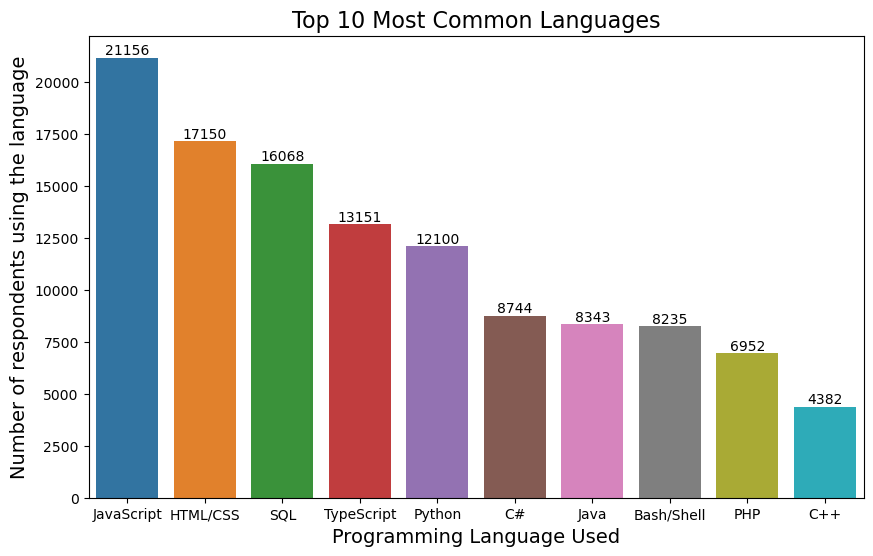

In [14]:
# Creating a larger figure
plt.figure(figsize=(10, 6))

# Creating a bar chart
ax = sns.barplot(x=lan_data.index, y=lan_data.values)

# Adding count labels on top of each bar
for i, number_respondent in enumerate(lan_data.values):
    plt.text(i, number_respondent, str(number_respondent), ha='center', va='bottom')

# Customizing the chart
plt.xlabel('Programming Language Used', fontsize=14)
plt.ylabel('Number of respondents using the language', fontsize=14)
plt.title('Top 10 Most Common Languages', fontsize=16)

# Displaying the chart
plt.show(ax)


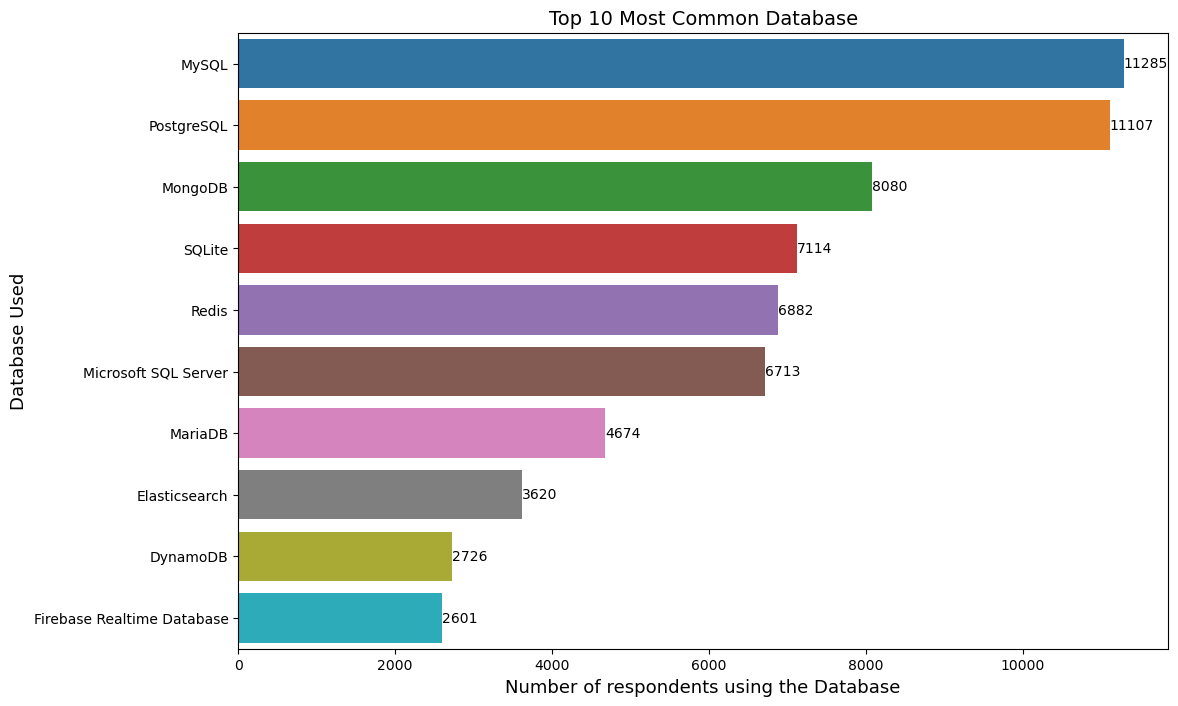

In [15]:
# Create a DataFrame containing only the respondents who have worked with JavaScript
df_js = normalize_dfs["LanguageHaveWorkedWith"][normalize_dfs["LanguageHaveWorkedWith"]["LanguageHaveWorkedWith"] == "JavaScript"]

# Create a DataFrame containing only the respondents who have worked with JavaScript
df_db_js = normalize_dfs["DatabaseHaveWorkedWith"][normalize_dfs["DatabaseHaveWorkedWith"].index.isin(df_js.index)]

# Analyze the frequency distribution of database experience among respondents who have worked with JavaScript
# Collecting the data to be plotted
db_data = df_db_js["DatabaseHaveWorkedWith"].value_counts().head(10)

# Creating a larger figure
plt.figure(figsize=(12, 8))

# Creating a horizontal bar plot using Seaborn
ax1 = sns.barplot(y=db_data.index, x=db_data.values, orient='h')

# Adding count numbers on the right side of each bar
for bar in ax1.containers[0]:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(int(bar.get_width())), ha="left", va="center")
    
# Customizing the chart
plt.xlabel('Number of respondents using the Database', fontsize=13)
plt.ylabel('Database Used', fontsize=13)
plt.title('Top 10 Most Common Database', fontsize=14)

# Displaying the chart
plt.show(ax1)
